# Thinking in tensors in PyTorch

Deep learning for neuroscientists - hands-on training  by [Piotr Migdał](https://p.migdal.pl) (2019). Version 0.2.


## Notebook 4: PyTorch optimization

We use linear regression as an example.

* [Linear regression](http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm)
* [Ordinary Least Squares Regression-Explained Visually](http://setosa.io/ev/ordinary-least-squares-regression/)
* [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import Parameter

## Optimization

Let's start with a problem suited for linear regression.

In [2]:
x = torch.tensor([[1.0, 4.4], 
                  [1.0, 6.1], 
                  [1.0, 6.6], 
                  [1.0, 7.2], 
                  [1.0, 9.1], 
                  [1.0, 11.0]])
y = torch.tensor([1.4, 3.1, 3.6, 4.2, 6.1, 8.0])

noise = torch.randn(y.size())
y.add_(0.1 * noise)  # let's add noise to make it more complicated :)

tensor([1.4674, 3.1919, 3.6235, 4.2110, 6.1561, 7.9903])

In [3]:
weights_ideal = torch.tensor([[-3.], [1.]])
weights = torch.randn((2, 1), requires_grad=True)

In [4]:
# at some point we want them to become sth like
weights_ideal

tensor([[-3.],
        [ 1.]])

In [6]:
x.mm(weights_ideal).t()

tensor([[1.4000, 3.1000, 3.6000, 4.2000, 6.1000, 8.0000]])

In [7]:
# we start with random weights
weights

tensor([[-1.3587],
        [-1.6237]], requires_grad=True)

In [8]:
x.mm(weights).t()

tensor([[ -8.5031, -11.2635, -12.0754, -13.0496, -16.1347, -19.2198]],
       grad_fn=<TBackward>)

## Calculating functions each time

In [26]:
weights = torch.randn((2, 1), requires_grad=True)
loss1 = []

for i in range(300):

    net_output = x.mm(weights).t()
    loss = (net_output - y).pow(2).mean()
    loss.backward()
    
    weights.data.add_(-0.0001 * weights.grad.data)
    # weights.grad.data.zero_()
    # gradients are being added cumulatively, so they need zeroing after each update!
    
    loss1.append(loss.item())

In [27]:
# new, modified weights
weights

tensor([[-1.4962],
        [ 0.8060]], requires_grad=True)

In [28]:
def show_loss(losses, logy=False):
    print("Minimal loss: {:.3f}".format(losses[-1]))
    if logy:
        plt.semilogy(range(len(losses)), losses)
    else:
        plt.plot(range(len(losses)), losses);
    plt.xlabel("Step")
    plt.ylabel("Loss")

Minimal loss: 1.011


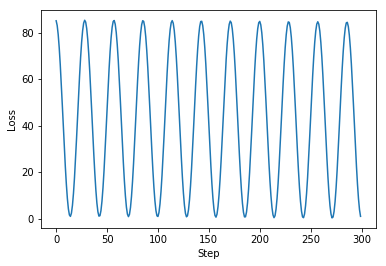

In [30]:
show_loss(loss1, logy=False)

## Module

It is very useful to create a network as a class.
Use `Parameter`. In this case it:

* computes gradient by default,
* registers it as a trainable parameters for optimizer.

In [31]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.weights = Parameter(torch.zeros(2, 1))
    
    def forward(self, x):
        output = x.mm(self.weights)
        return output.view(-1)

In [32]:
model = Model()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [33]:
list(model.parameters())

[Parameter containing:
 tensor([[0.],
         [0.]], requires_grad=True)]

In [36]:
loss2 = []
for i in range(3000):
    
    outputs = model(x)
    loss = criterion(outputs, y)
    loss2.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()        
    optimizer.step()

Minimal loss: 0.001


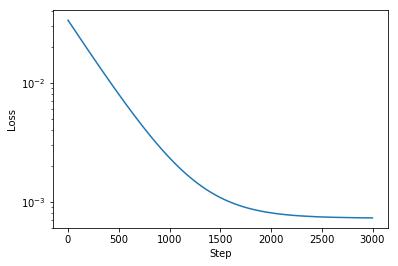

In [37]:
show_loss(loss2, logy=True)

In [38]:
list(model.parameters())

[Parameter containing:
 tensor([[-2.8761],
         [ 0.9887]], requires_grad=True)]

In [39]:
model.weights

Parameter containing:
tensor([[-2.8761],
        [ 0.9887]], requires_grad=True)

## Module - version with nn.Linear 

Some parameters can be directly used from `nn` library. It makes it slightly simpler than manually writing all expressions.


In [40]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(2, 1, bias=False)
    
    def forward(self, x):
        output = self.fc(x)
        return output.view(-1)

In [41]:
model = Model()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [42]:
model

Model(
  (fc): Linear(in_features=2, out_features=1, bias=False)
)

In [43]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2423, -0.2087]], requires_grad=True)]

In [44]:
loss3 = []
for i in range(3000):
    outputs = model(x)
    loss = criterion(outputs, y)
    loss3.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()        
    optimizer.step()

Minimal loss: 0.001


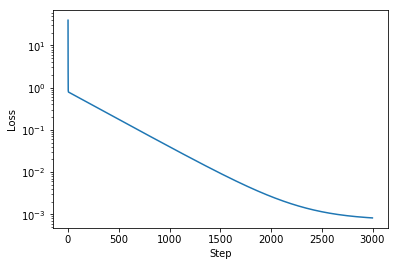

In [45]:
show_loss(loss3, logy=True)

In [46]:
outputs

tensor([1.4869, 3.1619, 3.6545, 4.2456, 6.1176, 7.9896],
       grad_fn=<ViewBackward>)

In [47]:
y

tensor([1.4674, 3.1919, 3.6235, 4.2110, 6.1561, 7.9903])

# Sequential

For some simple models, we can just compose layers using `nn.Sequential`. Sometimes it's convenient, but often only for sub-parts of the network.

In [53]:
#model = nn.Sequential(
#    nn.Linear(2, 1)
#)
# or even: model = nn.Linear(2, 1)

model = nn.Linear(2, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [54]:
model

Linear(in_features=2, out_features=1, bias=True)

In [55]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.5594, -0.4183]], requires_grad=True), Parameter containing:
 tensor([0.2490], requires_grad=True)]

In [56]:
loss4 = []
for i in range(1000):

    outputs = model(x)
    loss = criterion(outputs, y)  # .unsqueeze(-1) 
    # depending on other operations sometimes we need to be careful
    # about shapes; sequueze/unsqueeze are common for PyTorch
    loss4.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()        
    optimizer.step()

In [58]:
outputs

tensor([[4.3611],
        [4.3984],
        [4.4094],
        [4.4226],
        [4.4644],
        [4.5061]], grad_fn=<AddmmBackward>)

In [62]:
y

tensor([1.4674, 3.1919, 3.6235, 4.2110, 6.1561, 7.9903])

In [60]:
outputs - y

tensor([[ 2.8937,  1.1692,  0.7376,  0.1501, -1.7950, -3.6292],
        [ 2.9310,  1.2066,  0.7749,  0.1874, -1.7577, -3.5918],
        [ 2.9420,  1.2176,  0.7859,  0.1984, -1.7467, -3.5808],
        [ 2.9552,  1.2308,  0.7991,  0.2116, -1.7335, -3.5676],
        [ 2.9969,  1.2725,  0.8408,  0.2534, -1.6918, -3.5259],
        [ 3.0387,  1.3142,  0.8826,  0.2951, -1.6500, -3.4842]],
       grad_fn=<SubBackward0>)

Minimal loss: 4.446


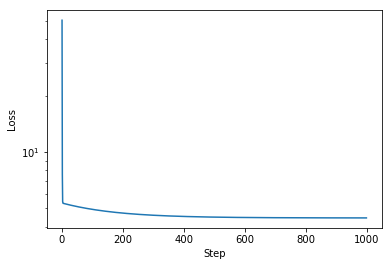

In [57]:
show_loss(loss4, logy=True)